In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import multiprocessing
import tifffile as tiff 
from skimage import io
# import skimage.io
# import skimage.exposure
# import skimage.morphology
# import skimage.measure
# import skimage.transform
# import skimage.segmentation
from PIL import Image, TiffTags

In [3]:
import tensorflow as tf
from tqdm import tqdm

In [4]:
main_dir = '/home/piyush/Downloads/DATA/gut mask data/good/'
# date_dir = ['15jul21', '16jul21']

# #read and sort all GUT Masks filenames
# dir_path = main_dir + date_dir[0] + '/'
# mask_listfiles = []

# for img_files in sorted(os.listdir(dir_path)): 
#     if img_files.endswith("_mask.tif"):
#         mask_listfiles.append(img_files)

In [5]:
# len(mask_listfiles)

In [6]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 6000
IMG_HEIGHT = 2048
IMG_CHANNELS = 4 #as RGB with alpha channel

In [7]:
TRAIN_PATH = main_dir + 'train/'
TEST_PATH = main_dir + 'test/'
# train_ids = next(os.walk(TRAIN_PATH))
# test_ids = next(os.walk(TEST_PATH))

In [8]:
# train_ids

In [9]:
train_mask_name, train_img_name = [], []

test_mask_name, test_img_name = [], []

for img_file in sorted(os.listdir(TRAIN_PATH)): 
    if img_file.endswith("BF_mask.tif"):
        train_mask_name.append(img_file)
    elif img_file.endswith("BF.png"):
        train_img_name.append(img_file)

for img_file in sorted(os.listdir(TEST_PATH)): 
    if img_file.endswith("BF_mask.tif"):
        test_mask_name.append(img_file)
    elif img_file.endswith("BF.png"):
        test_img_name.append(img_file)

In [10]:
train_mask_name

['15jul21_B1_BF_mask.tif',
 '15jul21_B2_BF_mask.tif',
 '15jul21_B3_BF_mask.tif',
 '15jul21_C1_BF_mask.tif',
 '15jul21_C4_BF_mask.tif',
 '15jul21_C5_BF_mask.tif',
 '15jul21_D5_BF_mask.tif',
 '15jul21_D6_BF_mask.tif',
 '16jul21_C4_BF_mask.tif',
 '16jul21_C5_BF_mask.tif',
 '16jul21_D5_BF_mask.tif',
 '16jul21_D6_BF_mask.tif']

In [11]:
train_img_name

['15jul21_B1_BF.png',
 '15jul21_B2_BF.png',
 '15jul21_B3_BF.png',
 '15jul21_C1_BF.png',
 '15jul21_C4_BF.png',
 '15jul21_C5_BF.png',
 '15jul21_D5_BF.png',
 '15jul21_D6_BF.png',
 '16jul21_C4_BF.png',
 '16jul21_C5_BF.png',
 '16jul21_D5_BF.png',
 '16jul21_D6_BF.png']

In [12]:
test_img_name

['16jul21_B1_BF.png',
 '16jul21_B2_BF.png',
 '16jul21_B3_BF.png',
 '16jul21_C1_BF.png']

In [13]:
test_mask_name

['16jul21_B1_BF_mask.tif',
 '16jul21_B2_BF_mask.tif',
 '16jul21_B3_BF_mask.tif',
 '16jul21_C1_BF_mask.tif']

In [14]:


X_train = np.zeros((len(train_img_name), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

In [15]:
img = io.imread(TRAIN_PATH + train_img_name[0])

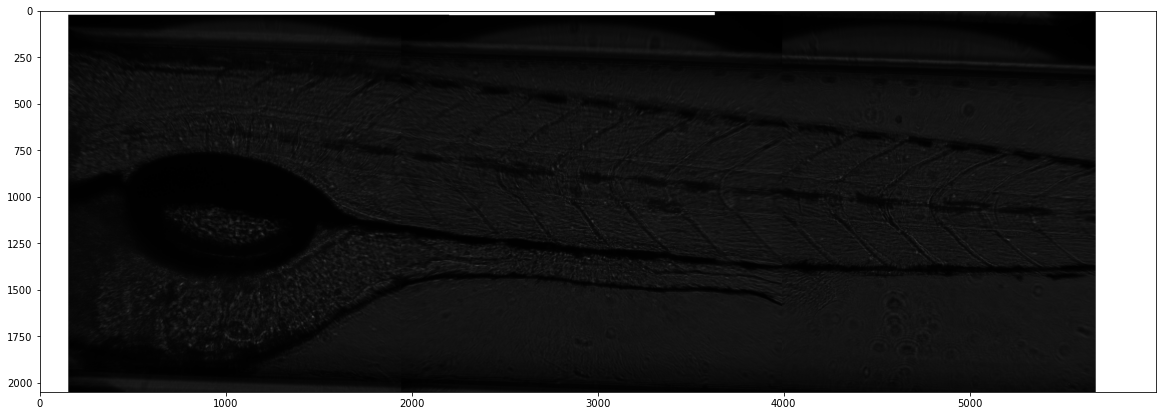

In [16]:
fig = plt.figure(figsize=(20,15))
plt.imshow(img, cmap='gray')

In [17]:
np.shape(img)

(2048, 6000, 4)

In [18]:
X_train[0].shape

(2048, 6000, 4)

In [19]:
# Load Train data into np arrays
X_train = np.zeros((len(train_img_name), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Y_train = np.zeros((len(train_img_name), IMG_HEIGHT, IMG_WIDTH), dtype=bool)

for i in tqdm(range(len(train_img_name))):
    img = io.imread(TRAIN_PATH + train_img_name[i]) #, as_gray=True) for converting to grayscale
    mask = io.imread(TRAIN_PATH + train_mask_name[i])
    X_train[i] = img
    Y_train[i] = mask


100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


In [20]:
mean_xtrain = np.mean(X_train)
std_xtrain = np.std(X_train)
max_xtrain = np.max(X_train)
min_xtrain = np.min(X_train)
print(f'Stats of X_train: mean={mean_xtrain:.3f}, std={std_xtrain:.3f}, min={min_xtrain}, max={max_xtrain}')

Stats of X_train: mean=71.295, std=101.985, min=0.0, max=255.0


In [21]:
# Load Test data into np arrays
X_test = np.zeros((len(test_img_name), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Y_test = np.zeros((len(test_img_name), IMG_HEIGHT, IMG_WIDTH), dtype=bool)

for i in tqdm(range(len(test_img_name))):
    img = io.imread(TEST_PATH + test_img_name[i]) #, as_gray=True) for converting to grayscale
    mask = io.imread(TEST_PATH + test_mask_name[i])
    X_test[i] = img
    Y_test[i] = mask

100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


In [22]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 6000,  0           []                               
                                 4)]                                                              
                                                                                                  
 lambda (Lambda)                (None, 2048, 6000,   0           ['input_1[0][0]']                
                                4)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 2048, 6000,   592         ['lambda[0][0]']                 
                                16)                                                           

2022-02-24 15:50:15.714634: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_gutmask.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)


2022-02-24 15:50:16.352173: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1966080000 exceeds 10% of free system memory.


Epoch 1/25


2022-02-24 15:50:19.548388: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1966080000 exceeds 10% of free system memory.
2022-02-24 15:50:19.548443: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1966080000 exceeds 10% of free system memory.
2022-02-24 15:50:19.548460: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1966080000 exceeds 10% of free system memory.
2022-02-24 15:50:19.548474: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1966080000 exceeds 10% of free system memory.


In [ ]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()


In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
